# Spatial matching graph

Author: [Levi John Wolf](http://github.com/ljwolf)


### Basic Usage

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import pandas

In [2]:
from libpysal.graph import Graph

In [3]:
points = np.row_stack([(10.2, 5.1), (4.7, 2.2), (5.3, 5.7), (2.7, 5.3), (7,4)])
gdf = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(*points.T))

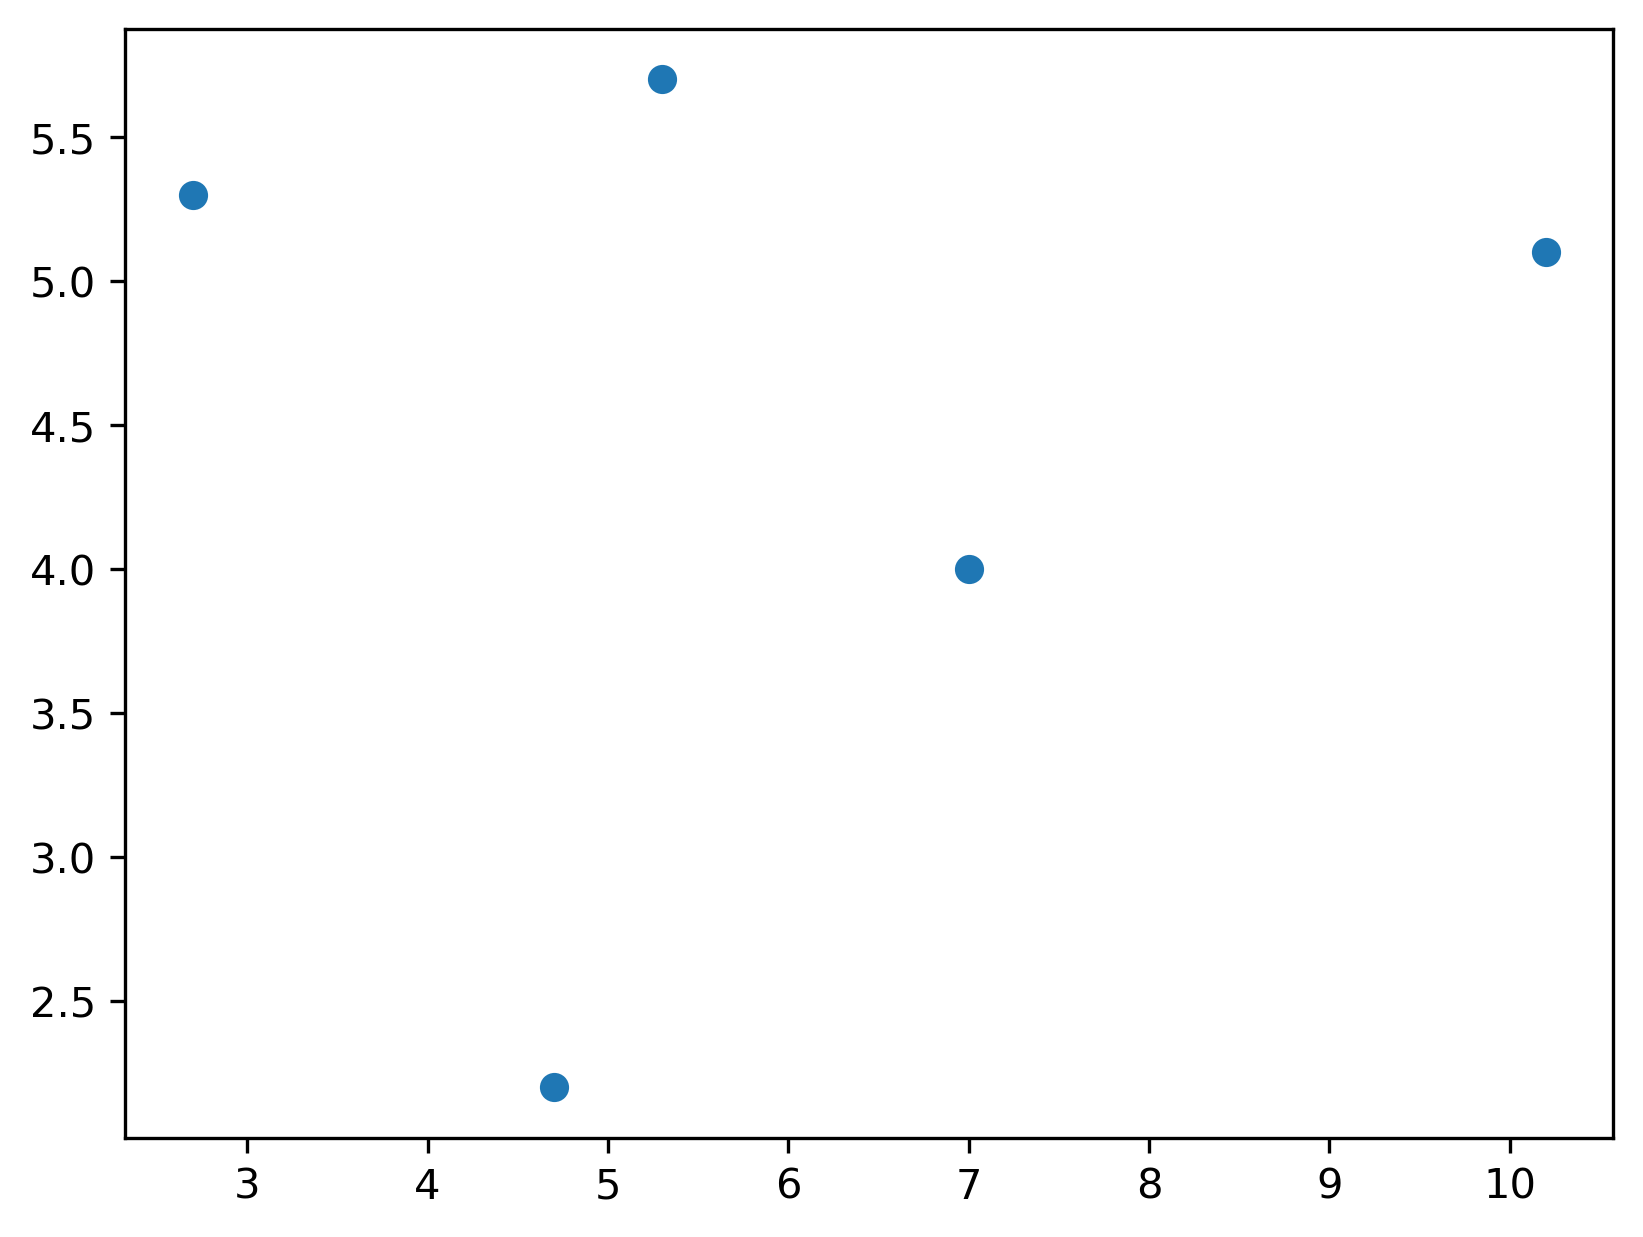

In [4]:
plt.scatter(*points.T)

In [5]:
g1 = Graph.build_spatial_matches(gdf.geometry, k=1)
g2 = Graph.build_spatial_matches(gdf.geometry, k=2)
g3 = Graph.build_spatial_matches(gdf.geometry, k=3)

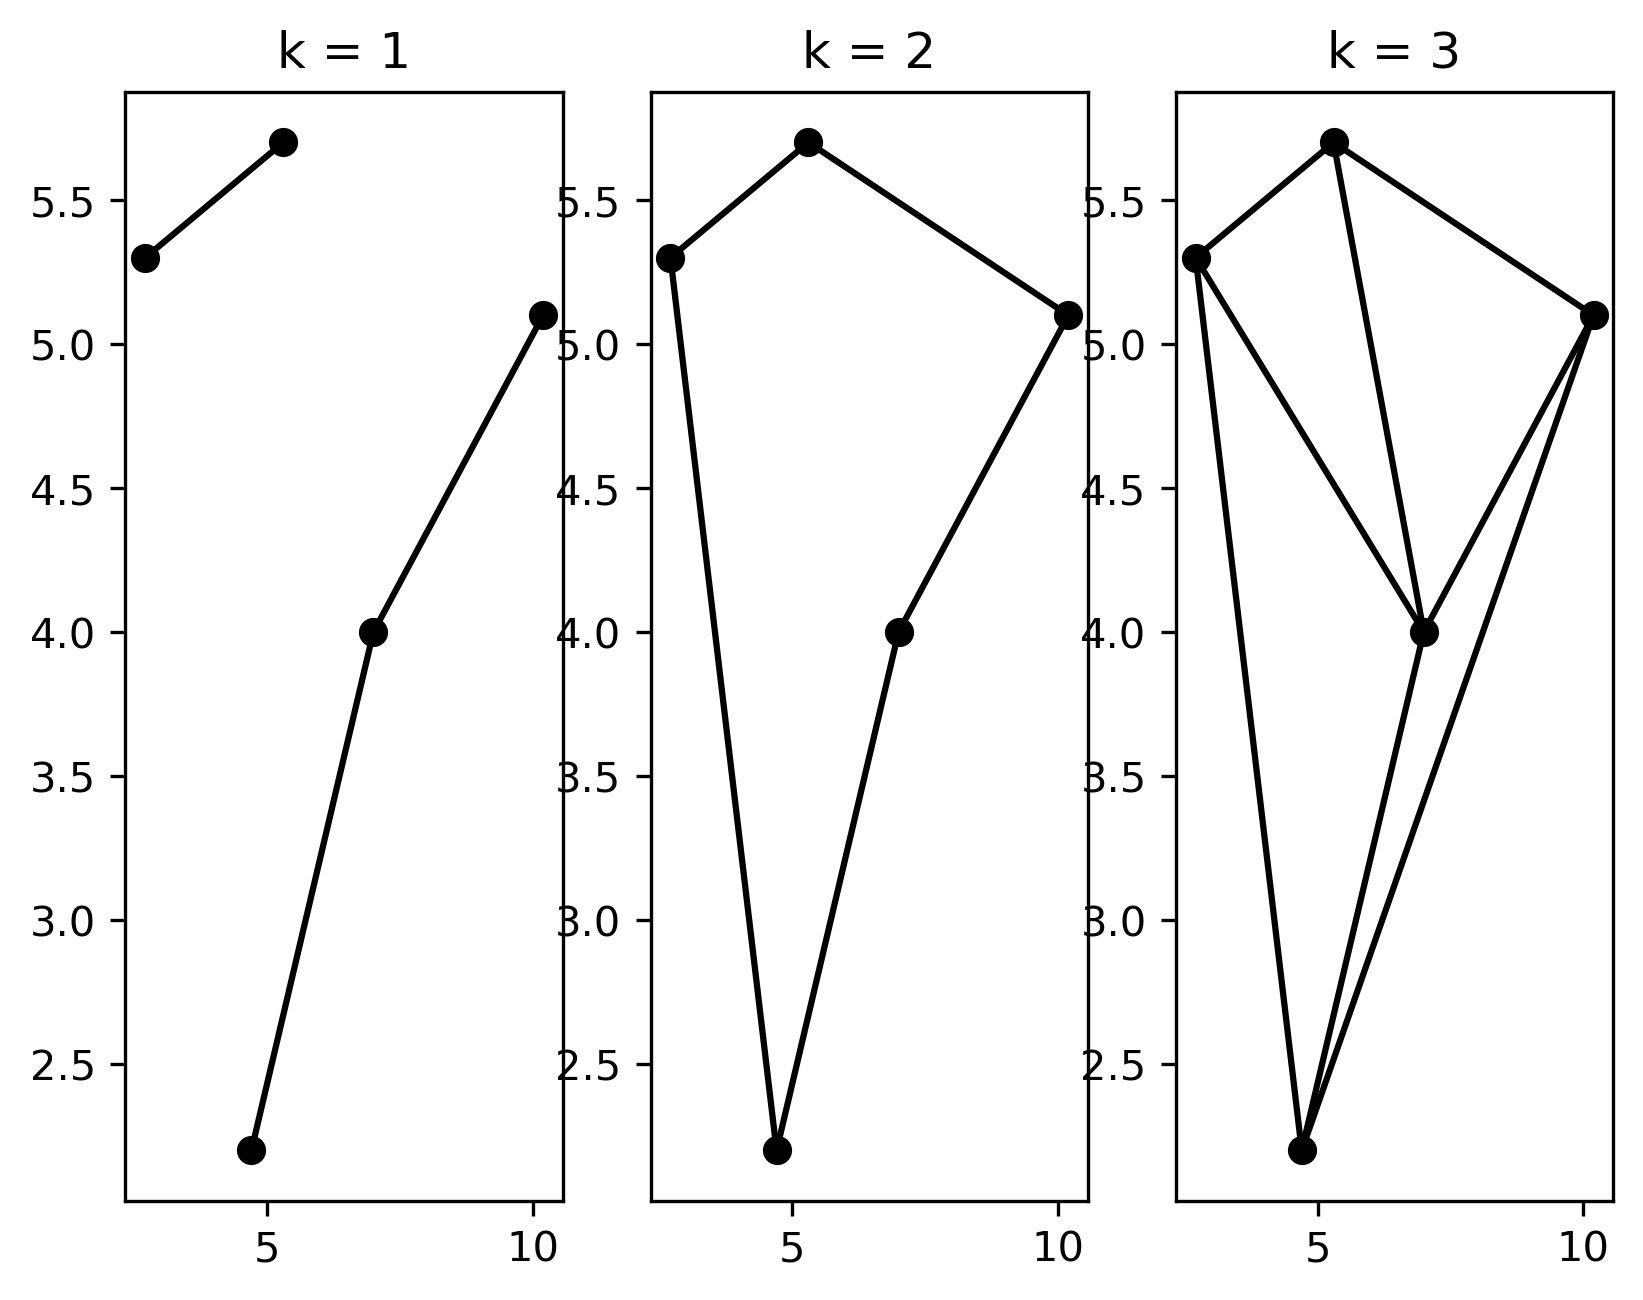

In [6]:
f, ax =plt.subplots(1,3)
for i,g in enumerate((g1, g2, g3)):
    g.plot(gdf, ax=ax[i])
    ax[i].set_title(f"k = {i+1}")

## Larger Problem

In [7]:
import geodatasets
stores = geopandas.read_file(geodatasets.get_path("geoda liquor_stores")).explode(
    index_parts=False
)

In [8]:
stores.head()

,id,placeid,geometry
0,0,ChIJnyLZdBTSD4gRbsa_hRGgPtc,POINT (1161395.910 1928443.285)
1,3,ChIJ5Vdx0AssDogRVjbNIyF3Mr4,POINT (1178227.792 1881864.522)
2,4,ChIJb5I6QwYsDogRe8R4E9K8mkk,POINT (1178151.911 1879212.002)
3,6,ChIJESl0mMfMD4gRy23-8soxKuw,POINT (1141552.993 1910193.701)
4,7,ChIJg28YOdvMD4gRiV2lZcjSVyQ,POINT (1144074.399 1910643.753)


In [9]:
stores = stores.set_index(stores.placeid)

Solving for this graph in larger data will take time. The solution technique is somewhere between $O(n^2)$ and $O(n^3)$ if the solver recognizes it's a matching problem.

In [10]:
g1 = Graph.build_spatial_matches(stores.geometry, k=1)
g5 = Graph.build_spatial_matches(stores.geometry, k=5)
g10 = Graph.build_spatial_matches(stores.geometry, k=10)

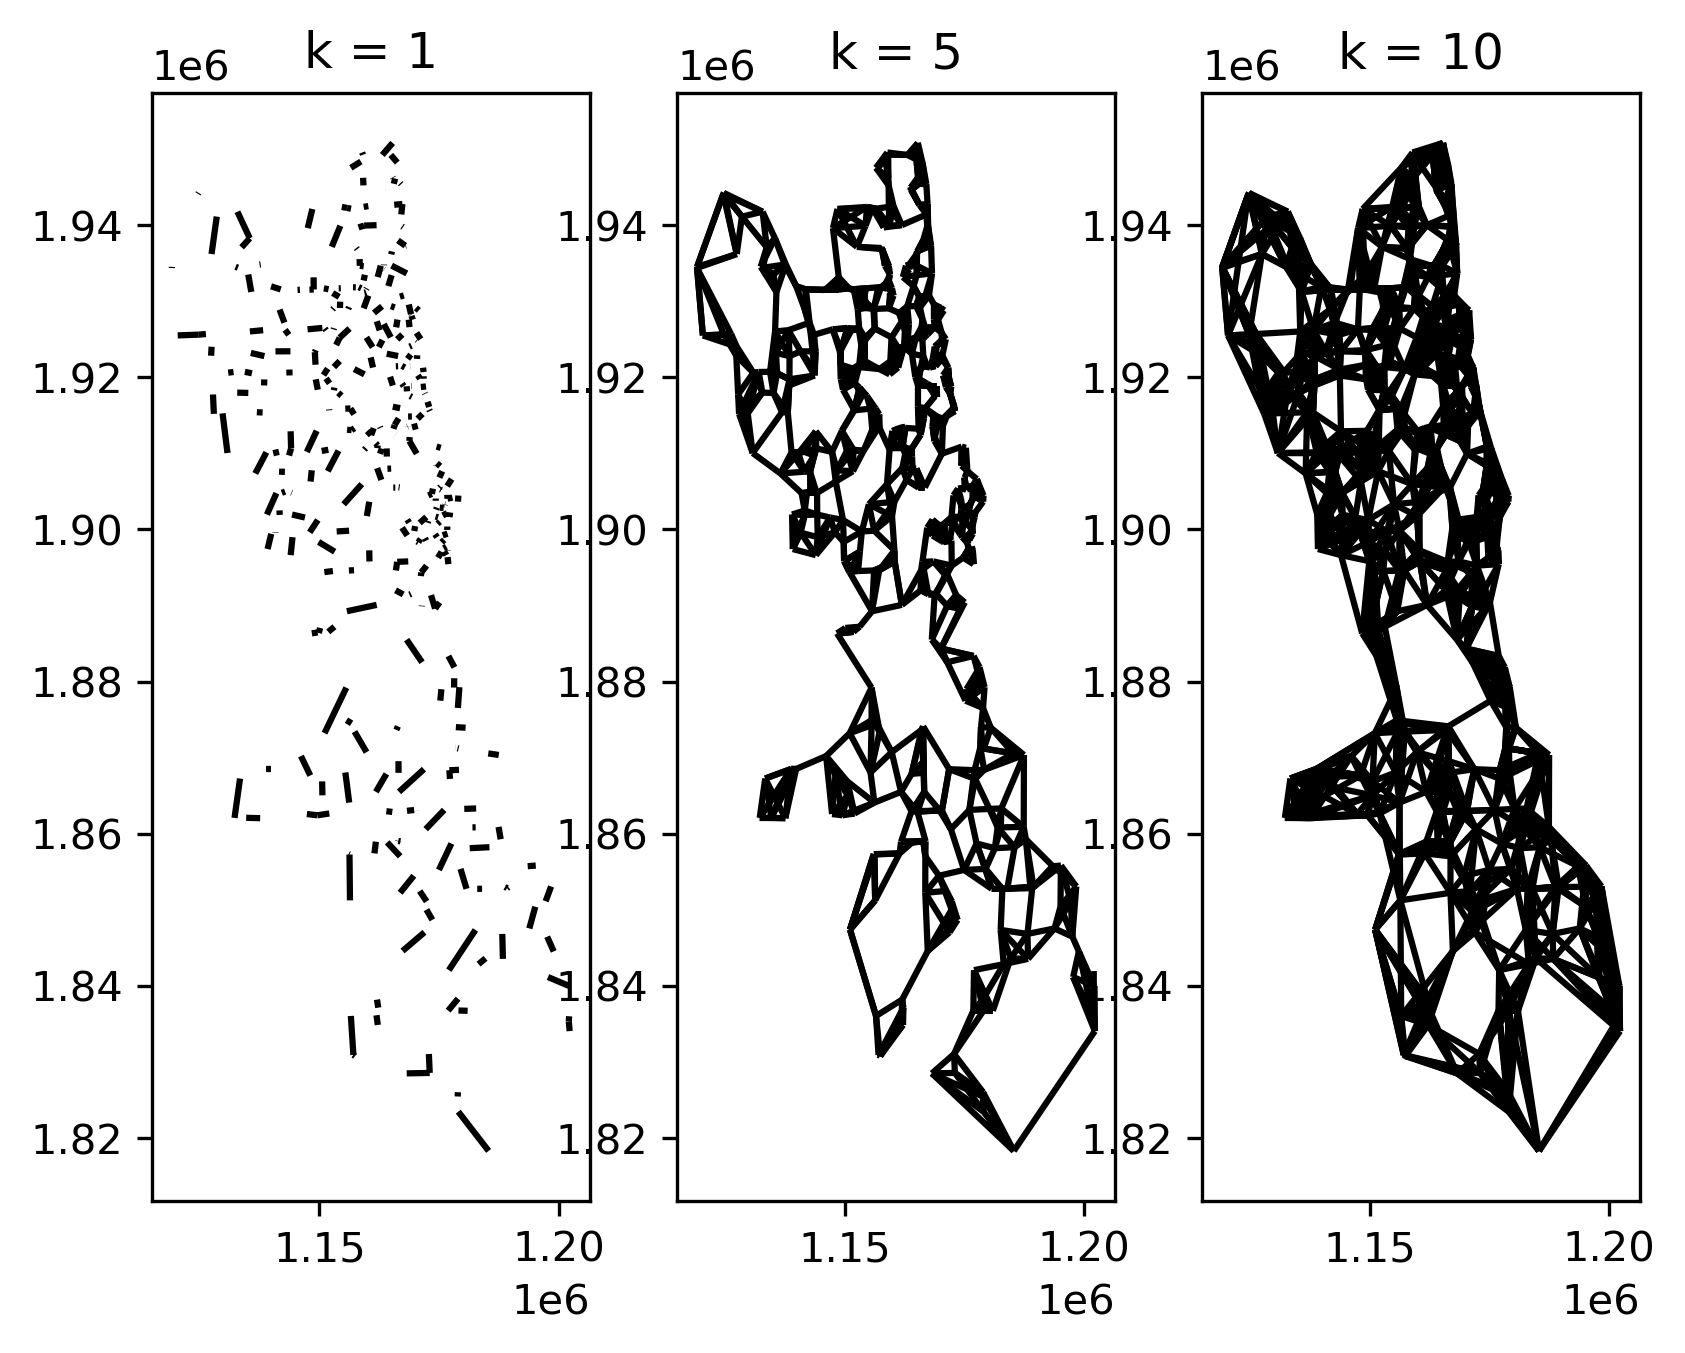

In [20]:
f, ax =plt.subplots(1,3)
for i,g in enumerate((g1, g5, g10)):
    g.plot(stores, ax=ax[i], nodes=False)
    ax[i].set_title(f"k = {(1, 5, 10)[i]}")

## Cross-matching

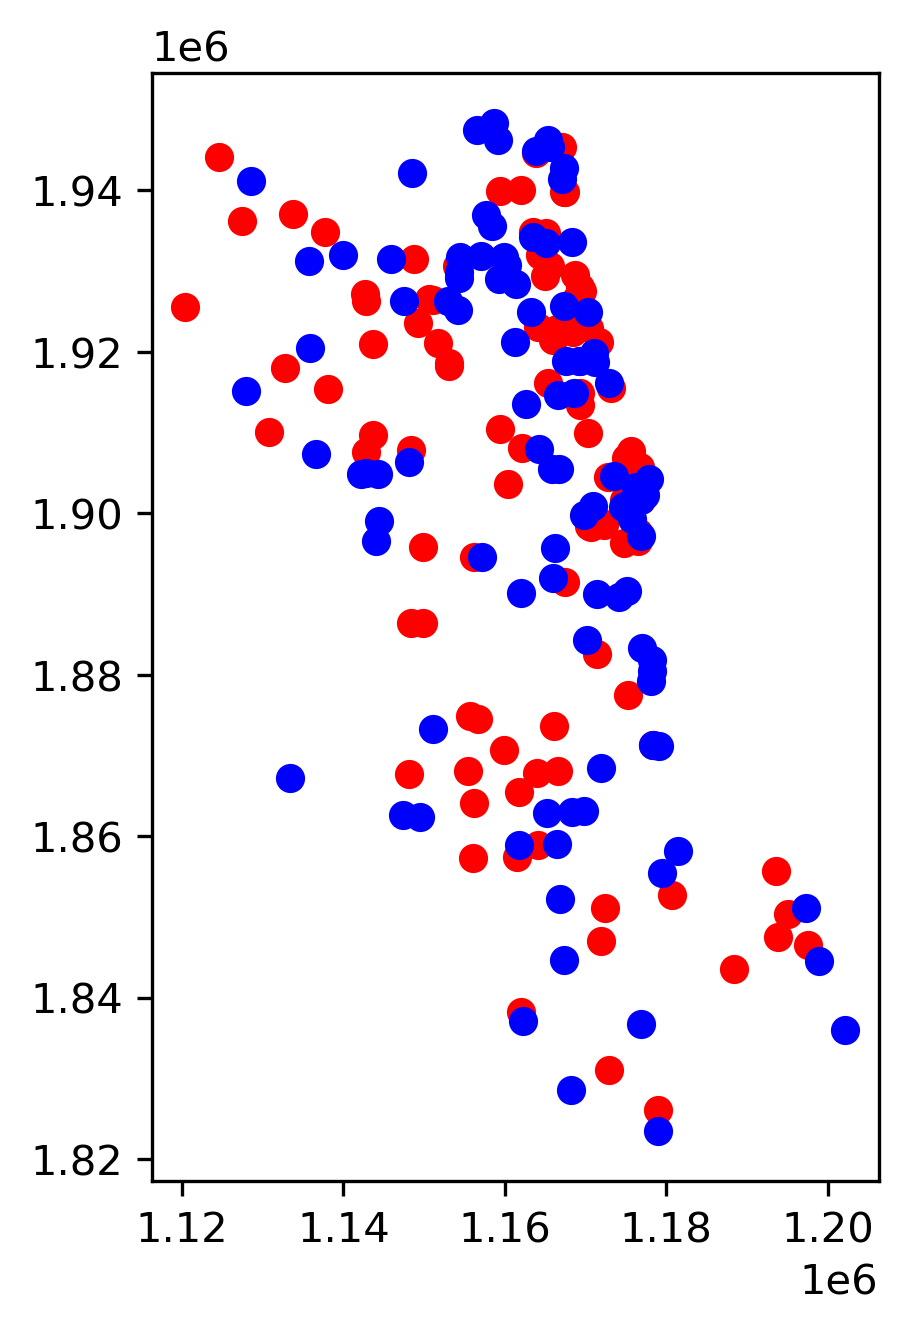

In [12]:
sources = stores.sample(100)
sinks = stores[~stores.index.isin(sources.index)].sample(100)
ax = sources.plot(color='red')
sinks.plot(color='blue', ax=ax)
plt.show()

In [13]:
from libpysal.graph._matching import _spatial_matching
import shapely

In [14]:
sources = stores.sample(100)
sinks = stores[~stores.index.isin(sources.index)].sample(100)

In [15]:
source_coordinates = sources.geometry.get_coordinates().values
sink_coordinates = sinks.geometry.get_coordinates().values

In [16]:
crosspattern_heads, crosspattern_tails, weights, mip = _spatial_matching(x=sink_coordinates, y = source_coordinates, n_matches=1, return_mip=True)

In [17]:
mip.sol_status

1

In [18]:
lines = shapely.linestrings(
    list( 
    zip(
        map(list, source_coordinates[crosspattern_heads]),
        map(list, sink_coordinates[crosspattern_tails])
    )
)
)

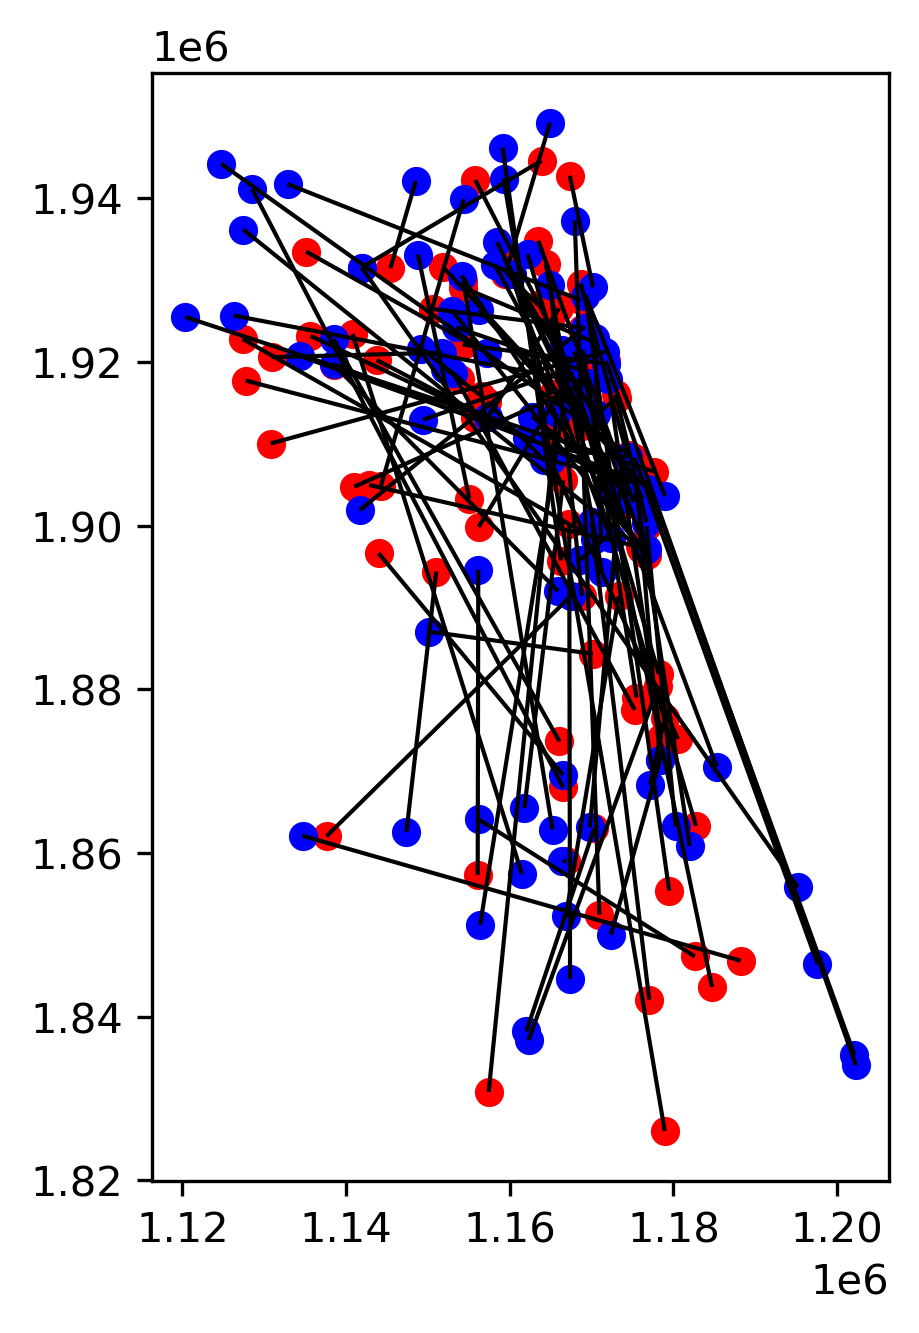

In [19]:
ax = sources.plot(color='red')
sinks.plot(color='blue', ax=ax)
geopandas.GeoSeries(lines).plot(linewidth=1, color='k', ax=ax)
plt.show()